# Predicting the diagnosis of heart diseases

## Introduction

Heart disease includes a number of conditions affecting the cardiovascular system. Some of the typical conditions include blood vessel obstruction by fatty plaque, arrhythmic heartbeat, and heart valve failures (Mayo Clinic, 2021). Heart disease conditions have been studied extensively and a number of risk factors have been identified. These risk factors include patients’ age, sex, presence of chest pain, serum cholesterol level, etc (Mayo Clinic, 2021). The Cleveland database included 76 such attributes associated with heart disease patients. The literature on heart disease favoured 14 of these attributes which we used a subset of them for this project.

For this project, our goal is to predict patients’ heart disease status (presence) given patients’ characteristics and symptoms found in the Cleveland database.

This dataset is processed from a database of 76 recorded attributes of a patient, only 14 of which are used in published experiments. The Cleveland dataset attempts to predict the diagnosis of heart disaease in a patient using 13 predictors (14 attributes): age, sex, chest pain type, resting blood pressure, cholestoral level, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise relative to rest, slope of peak exercise ST segment, number of major vessels colored by fluoroscopy, and thalassemia range.

## Preliminary exploratory data analysis

In [12]:
# Set the seed to ensure reproducibility
set.seed(0)
library(tidyverse) 
library(tidymodels)

options(repr.matrix.max.rows = 6)

In [13]:
# Read the data set into R from source
col_names <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
# Clean and wrangle data, remove missing values
heart_disease <- read_csv(url, col_names=col_names) %>%
    filter(thal != "?") %>%
    filter(ca != "?") %>%
    mutate(hd = ifelse(num > 0, "Yes", "No")) %>% #recode heart disease status into presence and non-presence
    mutate(hd = as_factor(hd), ca = as.double(ca), thal = as.double(thal))
heart_disease 


Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,No
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2,Yes
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3,Yes
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1,Yes


In [14]:
# Split training and testing data
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = hd)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

In [15]:
# Summarise the training data
training_summary <- heart_disease_training %>%
    group_by(hd) %>%
    summarise(n = n(), mean_trestbps = mean(trestbps), mean_chol = mean(chol), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak), mean_slope=mean(slope))
training_summary

`summarise()` ungrouping output (override with `.groups` argument)



hd,n,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak,mean_slope
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,120,129.0083,238.1083,159.7833,0.622500,1.366667
Yes,103,136.6311,256.0485,141.0000,1.570874,1.815534


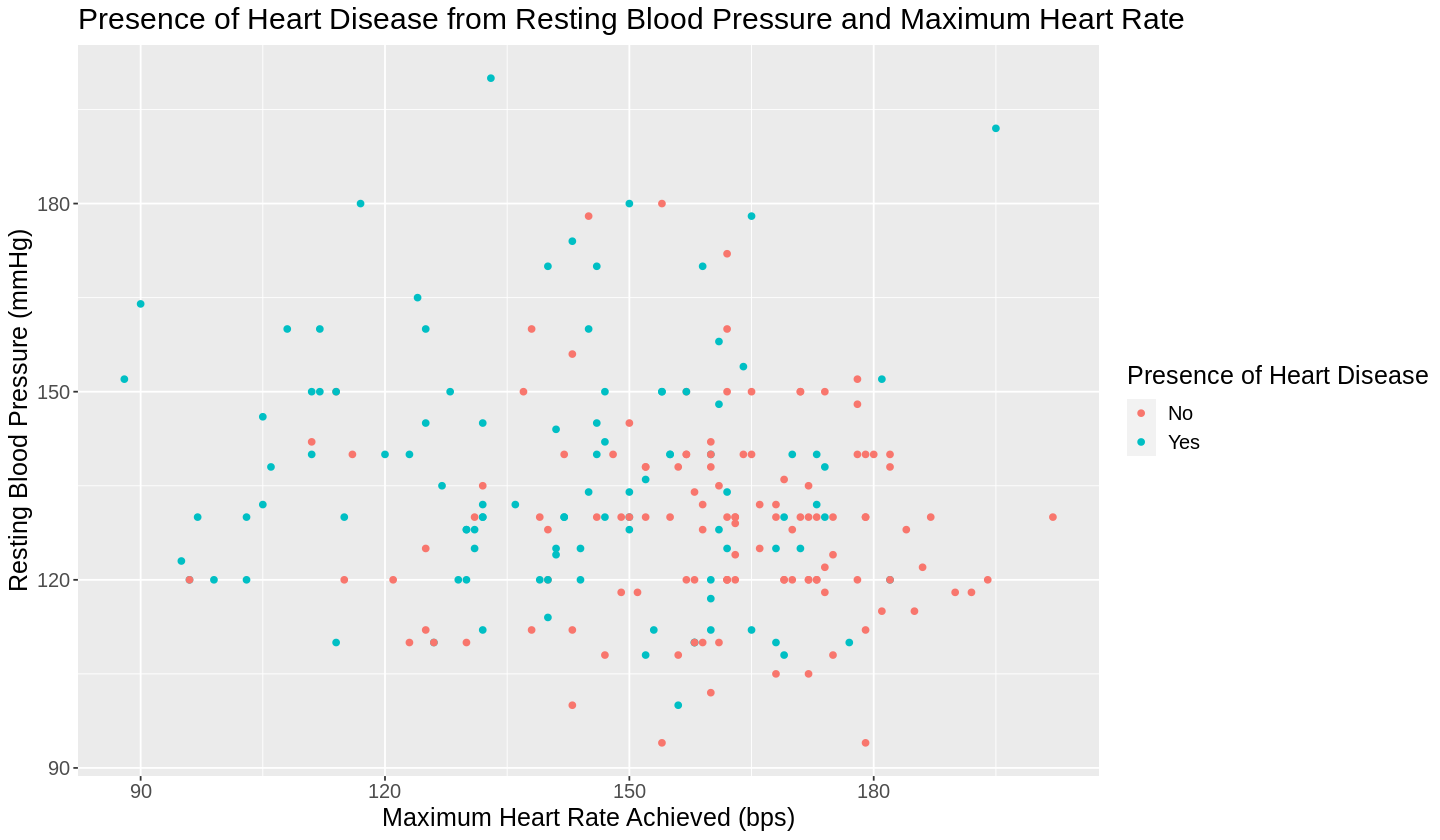

In [16]:
# Graph visualizing the relationship between some predictor values and the presence of heart disease
options(repr.plot.width = 12, repr.plot.height = 7)
heart_disease_plot <- ggplot(heart_disease_training, aes(x=thalach, y=trestbps, color=hd)) +
    geom_point() +
    labs(x="Maximum Heart Rate Achieved (bps)", y="Resting Blood Pressure (mmHg)", color="Presence of Heart Disease") +
    ggtitle("Presence of Heart Disease from Resting Blood Pressure and Maximum Heart Rate") +
    theme(text = element_text(size = 15))
heart_disease_plot

In [37]:
heart_disease_recipe <- recipe(hd ~ trestbps + chol + thalach, data=heart_disease_training) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

In [38]:
knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_disease_vfold <- vfold_cv(heart_disease_training, v=5, strata=hd)

In [39]:
knn_results <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = heart_disease_vfold, grid = 15) %>%
    collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.6722222,5,0.02545475,Model09
10,accuracy,binary,0.6722222,5,0.02545475,Model10
11,accuracy,binary,0.6680808,5,0.01806175,Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.6275758,5,0.02940921,Model08
1,accuracy,binary,0.5605051,5,0.03350522,Model01
2,accuracy,binary,0.5605051,5,0.03350522,Model02


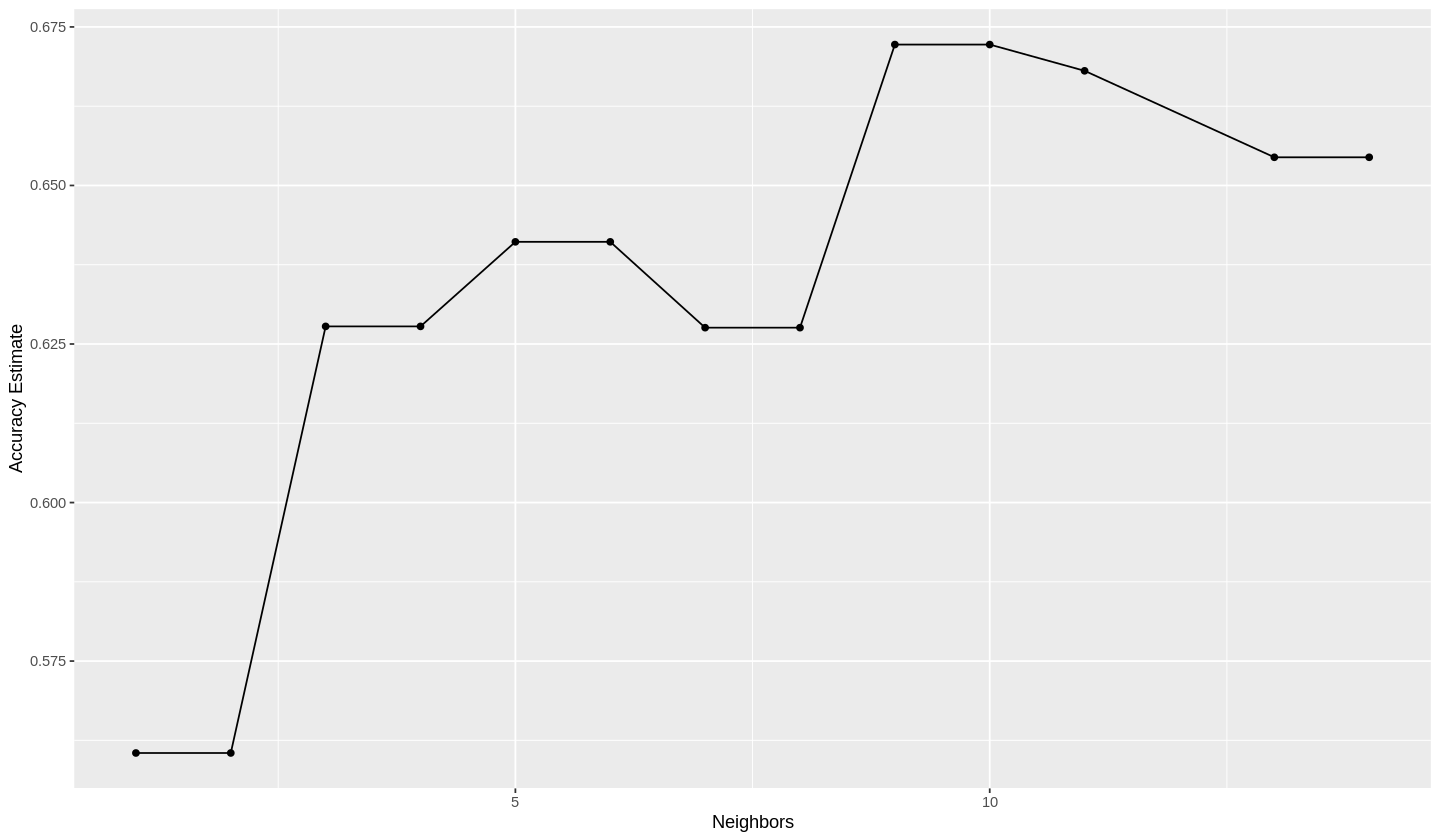

In [40]:
accuracies <- knn_results %>% 
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k

In [44]:
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=5) %>%
    set_engine("kknn") %>%
    set_mode("classification")

heart_disease_fit <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_spec) %>%
    fit(data=heart_disease_training)

In [45]:
heart_disease_predictions <- predict(heart_disease_fit, heart_disease_testing) %>%
    bind_cols(heart_disease_testing)

In [46]:
heart_disease_accuracy <- heart_disease_predictions %>%
        metrics(truth = hd, estimate = .pred_class) %>%
        slice(1) %>%
        select(.estimate) %>%
        pull()

heart_disease_conf_mat <- heart_disease_predictions %>%
        conf_mat(truth = hd, estimate = .pred_class)
heart_disease_accuracy

heart_disease_conf_mat

[1] 0.6351351

          Truth
Prediction No Yes
       No  27  14
       Yes 13  20

## Methods

We first decided to eliminate predictors that are categorical as opposed to quantitative as they would not work with a K-nearest neighbour model. We also eliminated predictors with missing data. We then mutated the heart disease diagnosis attribute to only include yes/no for a heart diagnosis as we are not interested in severity from a scale of 0-4 (0 is no and 1-4 is yes). We are planning to use a k-nearest neighbour classification model. We will create a recipe that will predict the status of heart disease diagnosis using the predictors we have not eliminated. We will then cross-validate our training data to find the best value of k, and then create a workflow with the recipe and model containing the ideal value of k. Finally, we will use this model to predict our testing data and determine the accuracy of our model using a confusion matrix. We will use a scatter plot to visualize the data.

## Expected outcomes and significance

We expect to find that patients with a higher age, level of cholesterol, and blood pressure are more likely to be diagnosed with heart disease, as they are commonly known contributors to heart disease. We are, however, unsure of the potential correlations between heart disease diagnosis and other predictors.

We can build a k-nn classification model that can accurately predict the presence of heart disease when given new patient data without a known diagnosis. This classifier allows for early intervention and identification of heart disease and gives patients the opportunity to start treatment early on which could save their lives. Determining the presence of heart disease enables patients and their families time to gather their financial resources before requiring a life-saving procedure.

### What future questions could this lead to?
- How strong of a predictor is each individual characteristic for a diagnosis of heart disease? (What is the weight of each predictor?)
- Which characteristics are the best predictors? 
- How can we target these characteristics early on in heart disease identification when patients are at a lower risk state?


## Citation

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988, July 1). Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. Retrieved November 4, 2021, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. 

Mayo Clinic Staff. (2021, February 9). Heart disease. Mayo Clinic. Retrieved November 9, 2021, from https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118. 

This data was collected by the following principal investigators for data collection at each institution:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation:Robert Detrano, M.D., Ph.D.
